In [2]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import phate, m_phate # Should throw no error in proper environment

#### Embedding Visualization TODOs
Data
- [x] PCA
- [ ] Use ALL train data for PCA?
- [ ] PCA Denoising eval on denoised Embedding drift

- [x] t-SNE
- [ ] Visualize t-SNE training Steps
- [ ] Refine with new paper

- [x] UMAP
- [x] UMAP Parameters

- [ ] Copy PHATE stuff
- [ ] Evaluate

Visualization
- [x] Live during training
- [x] 3D
- [ ] With trajectory

**Environment:** Please use another environment (`phate-env`) here

# Embedding Visualization

## Import Data

In [3]:
# ==== MNIST ========
#dataset = "mnist"

#run = "mnist_MLP_32_0.9595"
# run = "mnist_MLP_128_0.9719"
#run = "mnist_CNN_64_0.9901"
#run = "mnist_ViT_64_0.9724"
#run = "mnist_ResNet_128_0.9907"

# ==== CIFAR 10 ========
#dataset = "cifar10"
#run = "cifar10_MLP_128_0.5672"

#run = "cifar10_CNN_128_0.8977"

#run = "cifar10_ViT_128_0.6311"
#run = "cifar10_ViT_128_0.6530_noisy"

#run = "cifar10_ResNet_128_0.8962"

# ==== CIFAR 100 ========
dataset = "cifar100"
#run = "cifar100_CNN_256_0.6060"
# run = "cifar100_CNN_256_0.6710"

#run = "cifar100_ViT_192_0.4760
#run = "cifar100_ViT_192_0.5429"

run = "cifar100_ResNet_128_0.6309"

In [4]:
dataset = "cifar10"
run = "run-0007-CNN_cifar10_128_0.8476"

In [5]:
from helper.data_manager import load_training_data

results = load_training_data(run)
results["embedding_drifts"] = {int(k): results["embedding_drifts"][k] for k in sorted(results["embedding_drifts"].keys(), key=int)}

embedding_list = results["subset_embeddings"].copy()
labels = results["subset_labels"]

## Recap: The Training

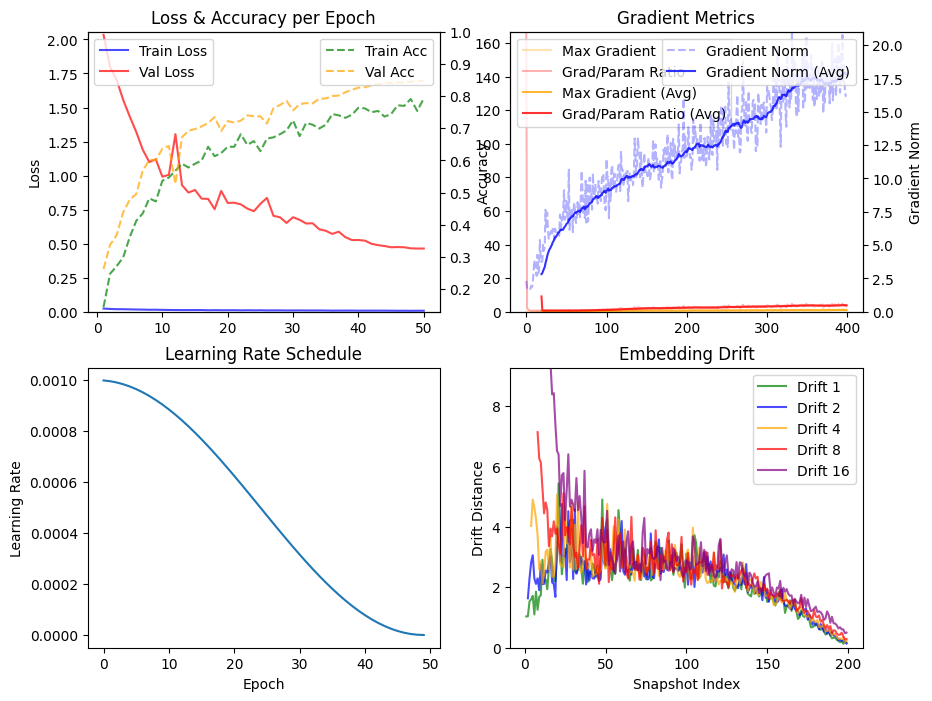

In [6]:
from helper.plots import plot_loss_accuracy, plot_gradients, plot_embedding_drift, plot_scheduled_lr

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
epochs = len(results["train_losses"])
plot_loss_accuracy(axs[0][0], epochs-1, epochs, results["train_losses"], results["val_losses"], results["train_accuracies"], results["val_accuracies"])
plot_gradients(axs[0][1], range(0, len(results["gradient_norms"])),results["gradient_norms"], results["max_gradients"], results["grad_param_ratios"], 20)
if "scheduler_history" in results.keys():
    plot_scheduled_lr(axs[1][0], results["scheduler_history"])
plot_embedding_drift(axs[1][1], results["embedding_drifts"])

## Embedding Drift
The evaluation measure in this work
- **Multi-scale skips**: for each snapshot index `i`, compare its embedding `E_i` to earlier snapshots `E_{i - 2**n}` for `n = 0,1,…,4` (skip lengths 1, 2, 4, 8, 16).  
- **Mean Euclidean distance**:  
  ```python
  drift = np.linalg.norm(current_snapshot - previous_snapshot, axis=1).mean()
- **Result:** a dict mapping each skip length to a time series of drift values, showing how rapidly—and at what scales—the embedding space is evolving.

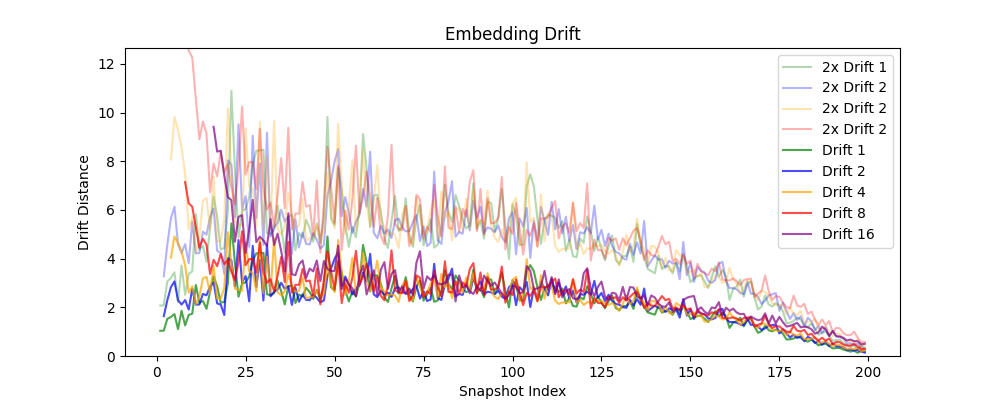

In [8]:
%matplotlib ipympl
%matplotlib widget
    
from herper.plots import plot_embedding_drift

embedding_drifts = results["embedding_drifts"].copy()
fig, axs = plt.subplots(1, 1, figsize=(10, 4))

# Plot 2x Drifts
axs.plot(range(1, len(embedding_drifts[1]) + 1), np.array(embedding_drifts[1]) * 2, color="green", label="2x Drift 1", alpha=0.3)
axs.plot(range(1, len(embedding_drifts[2]) + 1), np.array(embedding_drifts[2]) * 2, color="blue", label="2x Drift 2", alpha=0.3)
axs.plot(range(1, len(embedding_drifts[4]) + 1), np.array(embedding_drifts[4]) * 2, color="orange", label="2x Drift 2", alpha=0.3)
axs.plot(range(1, len(embedding_drifts[8]) + 1), np.array(embedding_drifts[8]) * 2, color="red", label="2x Drift 2", alpha=0.3)
plot_embedding_drift(axs, embedding_drifts, max_multiply=1.5)

plt.legend()
plt.show()

# Visualizations PCA

### PCA visualizations can be based on different bases

In [9]:
from helper.visualization import generate_projections, visualization_drift_vs_embedding_drift, denoise_projections
from helper.plots import show_with_slider, show_multiple_projections_with_slider

ModuleNotFoundError: No module named 'tqdm'

In [10]:
projections_pca_first = generate_projections(
    embeddings_list=embedding_list,
    method='pca',
    pca_fit_basis='first',
)
projections_pca_last = generate_projections(
    embeddings_list=embedding_list,
    method='pca',
    pca_fit_basis='last',
)
projections_pca_all = generate_projections(
    embeddings_list=embedding_list,
    method='pca',
    pca_fit_basis='all',
)

NameError: name 'generate_projections' is not defined

In [9]:
projections_pca_window = generate_projections(
    embeddings_list=embedding_list,
    method='pca',
    pca_fit_basis='window',
    window_size=16,
)

### Visualization
The 2D visualization here has a slider for epochs. You can also press Play, Pause and Stop

Optionally, a translation between the noisy steps can be activated to better track points moving far distances.

In [10]:
# CIFAR100 Legend
from helper.plots import show_cifar100_legend
if dataset == "cifar100":
    show_cifar100_legend(cmap = "tab20")

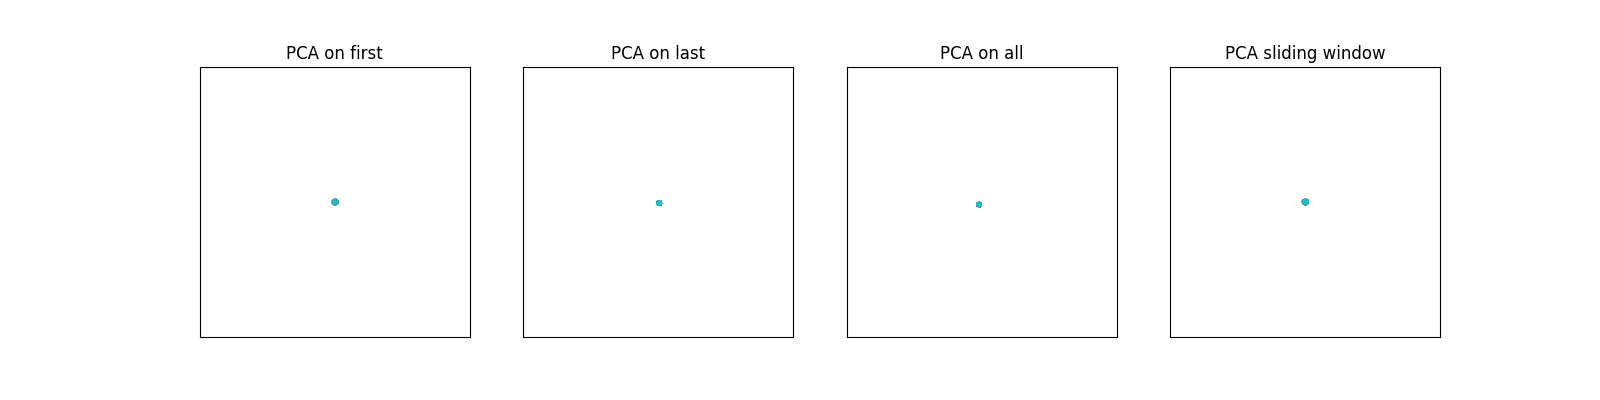

In [11]:
show_multiple_projections_with_slider(
    projections_list=[projections_pca_first, projections_pca_last, projections_pca_all, projections_pca_window],
    labels=labels,
    titles=["PCA on first", "PCA on last", "PCA on all", "PCA sliding window"],
    interpolate=False, # TRANSLATION via linear interpolation
    steps_per_transition=2, # interpolation steps
    figsize_per_plot=(4, 4),
    dataset=dataset,
    alpha=0.8,
    dot_size=7 # 12
)

Series 1 - Correlation: 0.9461
Series 2 - Correlation: 0.9295
Series 4 - Correlation: 0.9223
Series 8 - Correlation: 0.9128
Series 16 - Correlation: 0.9258
Mean Correlation: 0.9273


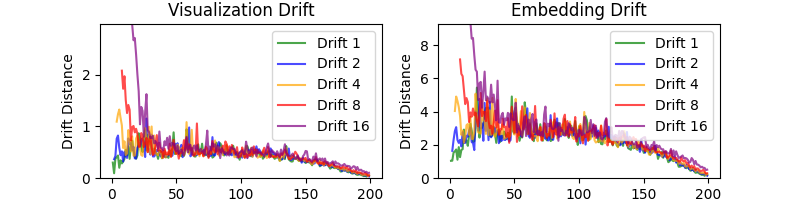

Series 1 - Correlation: 0.9526
Series 2 - Correlation: 0.9518
Series 4 - Correlation: 0.9515
Series 8 - Correlation: 0.9463
Series 16 - Correlation: 0.9592
Mean Correlation: 0.9523


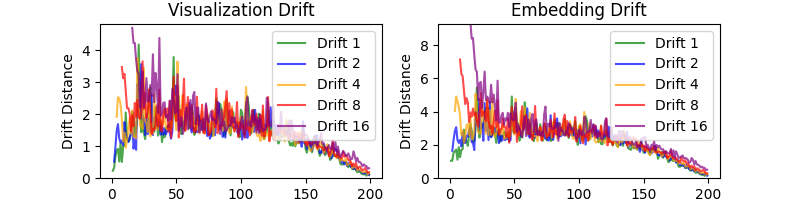

Series 1 - Correlation: 0.9563
Series 2 - Correlation: 0.9552
Series 4 - Correlation: 0.9512
Series 8 - Correlation: 0.9438
Series 16 - Correlation: 0.9578
Mean Correlation: 0.9529


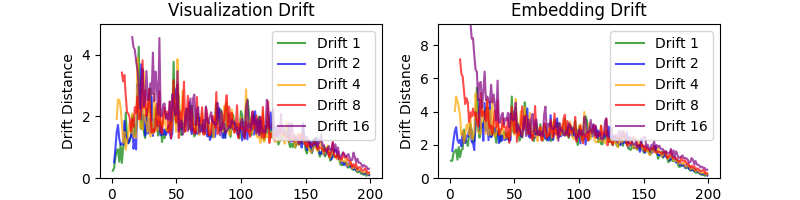

Series 1 - Correlation: 0.9486
Series 2 - Correlation: 0.9361
Series 4 - Correlation: 0.9320
Series 8 - Correlation: 0.8954
Series 16 - Correlation: 0.9097
Mean Correlation: 0.9244


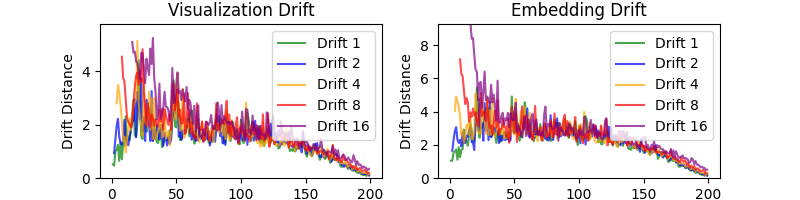

0.9243997115699736

In [12]:
visualization_drift_vs_embedding_drift(projections_pca_first, embedding_drifts, figsize=(8, 2))
visualization_drift_vs_embedding_drift(projections_pca_last, embedding_drifts, figsize=(8, 2))
visualization_drift_vs_embedding_drift(projections_pca_all, embedding_drifts, figsize=(8, 2))
visualization_drift_vs_embedding_drift(projections_pca_window, embedding_drifts, figsize=(8, 2))

In [13]:
# projections_filtered, labels_filtered = filter_classes(projections_pca_window, labels, [4, 30, 55, 72, 95])

### Denoising
As the embedding snapshots during training are made within one epoch at fixed, but arbitrary intervals, with varying samples and potentially augmented images, they are very noisy.

As a result, the values can only be seen as an indicator, not as an exact measurement of the embedding.

Therefore, we can apply denoising to get a better overall picture

In [14]:
projections_pca_first = denoise_projections(projections_pca_first, window_size=15, blend=0.9, mode='window')
projections_pca_last = denoise_projections(projections_pca_last, window_size=15, blend=0.9, mode='window')
projections_pca_all = denoise_projections(projections_pca_all, window_size=15, blend=0.9, mode='window')
projections_pca_window = denoise_projections(projections_pca_window, window_size=15, blend=0.9, mode='window')

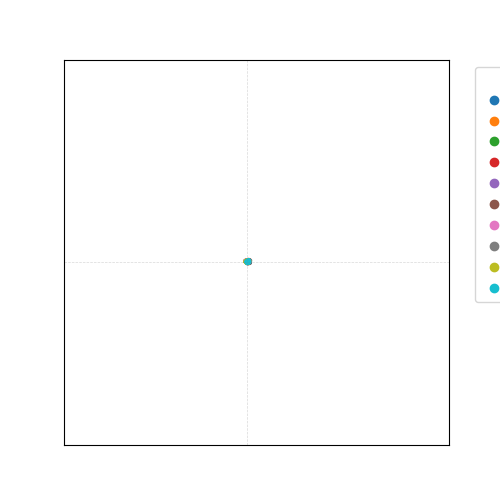

In [15]:
show_with_slider(
    projections_pca_window,
    labels=labels,
    interpolate=True,
    steps_per_transition=1,
    alpha=1,
    dataset=dataset,
    show_legend=False if dataset == "cifar100" else True,
)

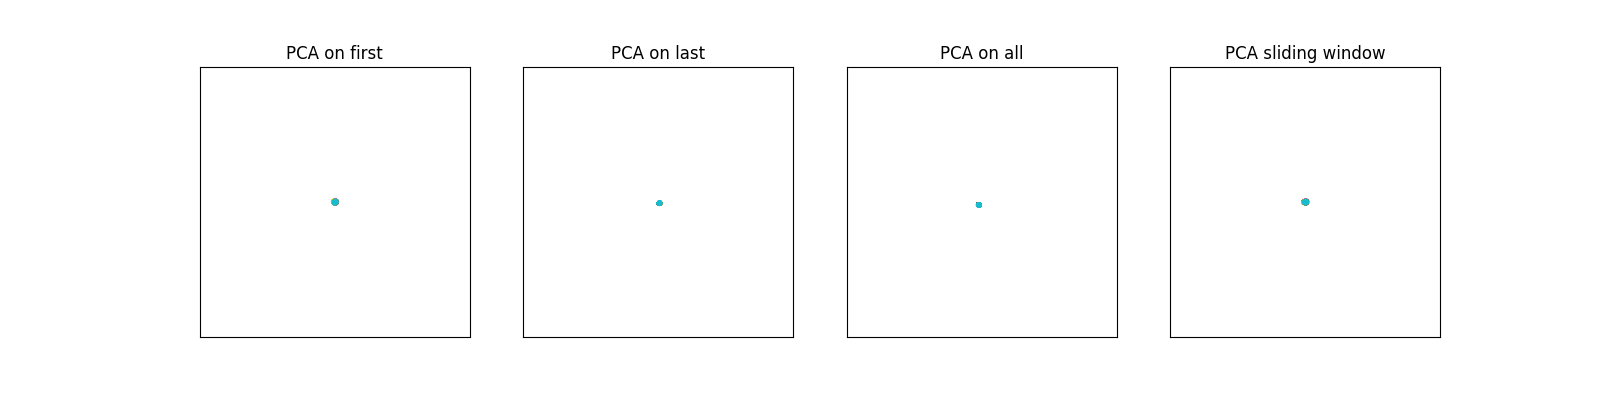

In [16]:
show_multiple_projections_with_slider(
    projections_list=[projections_pca_first, projections_pca_last, projections_pca_all, projections_pca_window],
    labels=labels,
    titles=["PCA on first", "PCA on last", "PCA on all", "PCA sliding window"],
    interpolate=False,
    steps_per_transition=2,
    figsize_per_plot=(4, 4),
    dataset=dataset,
    alpha=0.8,
    dot_size=7 # 12
)

Series 1 - Correlation: 0.5673
Series 2 - Correlation: 0.4468
Series 4 - Correlation: 0.5565
Series 8 - Correlation: 0.7007
Series 16 - Correlation: 0.8373
Mean Correlation: 0.6217


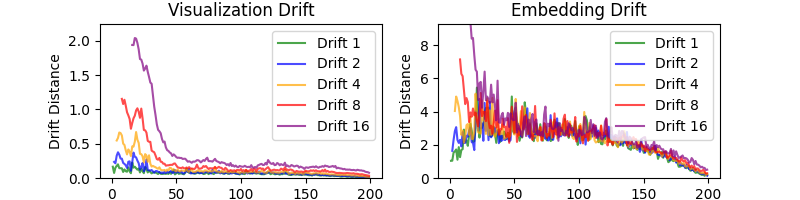

Series 1 - Correlation: 0.8608
Series 2 - Correlation: 0.7369
Series 4 - Correlation: 0.7435
Series 8 - Correlation: 0.8113
Series 16 - Correlation: 0.8876
Mean Correlation: 0.8080


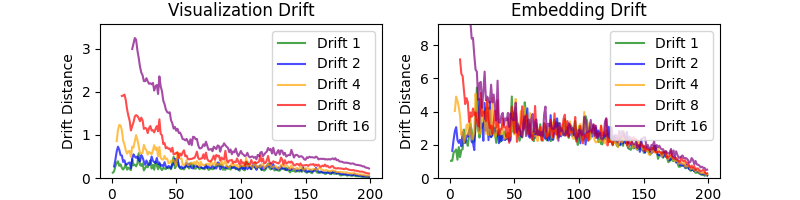

Series 1 - Correlation: 0.8628
Series 2 - Correlation: 0.7430
Series 4 - Correlation: 0.7481
Series 8 - Correlation: 0.8070
Series 16 - Correlation: 0.8789
Mean Correlation: 0.8080


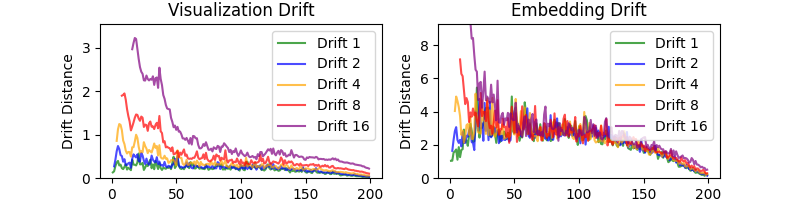

Series 1 - Correlation: 0.7975
Series 2 - Correlation: 0.6912
Series 4 - Correlation: 0.7697
Series 8 - Correlation: 0.8180
Series 16 - Correlation: 0.8373
Mean Correlation: 0.7827


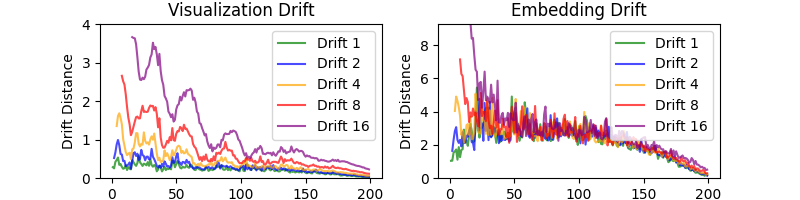

0.7827405859661057

In [17]:
visualization_drift_vs_embedding_drift(projections_pca_first, embedding_drifts, figsize=(8, 2))
visualization_drift_vs_embedding_drift(projections_pca_last, embedding_drifts, figsize=(8, 2))
visualization_drift_vs_embedding_drift(projections_pca_all, embedding_drifts, figsize=(8, 2))
visualization_drift_vs_embedding_drift(projections_pca_window, embedding_drifts, figsize=(8, 2))

#### Now compared to denoised Embeddings...

Series 1 - Correlation: 0.9103
Series 2 - Correlation: 0.9399
Series 4 - Correlation: 0.9618
Series 8 - Correlation: 0.9678
Series 16 - Correlation: 0.9690
Mean Correlation: 0.9497


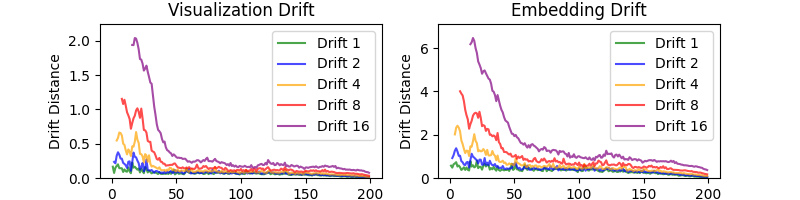

Series 1 - Correlation: 0.9282
Series 2 - Correlation: 0.9569
Series 4 - Correlation: 0.9826
Series 8 - Correlation: 0.9906
Series 16 - Correlation: 0.9931
Mean Correlation: 0.9703


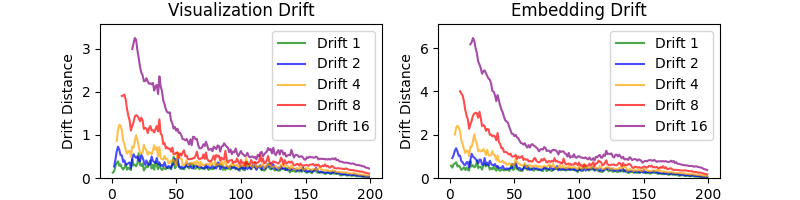

Series 1 - Correlation: 0.9312
Series 2 - Correlation: 0.9529
Series 4 - Correlation: 0.9785
Series 8 - Correlation: 0.9870
Series 16 - Correlation: 0.9890
Mean Correlation: 0.9677


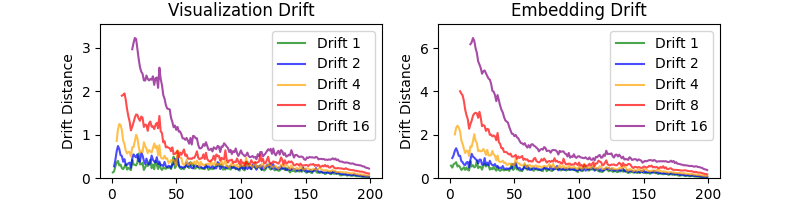

Series 1 - Correlation: 0.9485
Series 2 - Correlation: 0.9431
Series 4 - Correlation: 0.9313
Series 8 - Correlation: 0.9116
Series 16 - Correlation: 0.9022
Mean Correlation: 0.9273


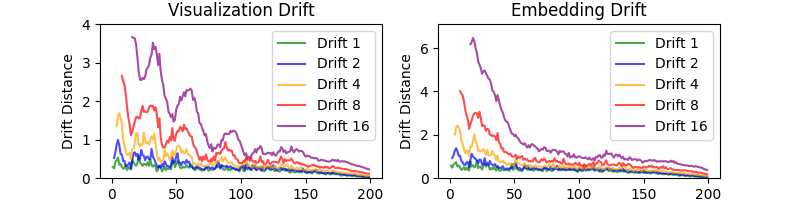

0.9273140797901969

In [18]:
denoised_embeddings = denoise_projections(embedding_list, window_size=15, blend=0.9, mode='window')

visualization_drift_vs_embedding_drift(projections_pca_first, denoised_embeddings, figsize=(8, 2), embeddings=True)
visualization_drift_vs_embedding_drift(projections_pca_last, denoised_embeddings, figsize=(8, 2), embeddings=True)
visualization_drift_vs_embedding_drift(projections_pca_all, denoised_embeddings, figsize=(8, 2), embeddings=True)
visualization_drift_vs_embedding_drift(projections_pca_window, denoised_embeddings, figsize=(8, 2), embeddings=True)

In [19]:
# Close interactivity of plots before
matplotlib.pyplot.close()

### 3D
We can also visualize 3D...

In [20]:
projections_3d = generate_projections(
    embeddings_list=embedding_list,
    method='pca',
    pca_fit_basis='window',
    out_dim=3 #3D
)

In [21]:
projections_3d = denoise_projections(projections_3d, window_size=15, blend=0.9, mode='window')

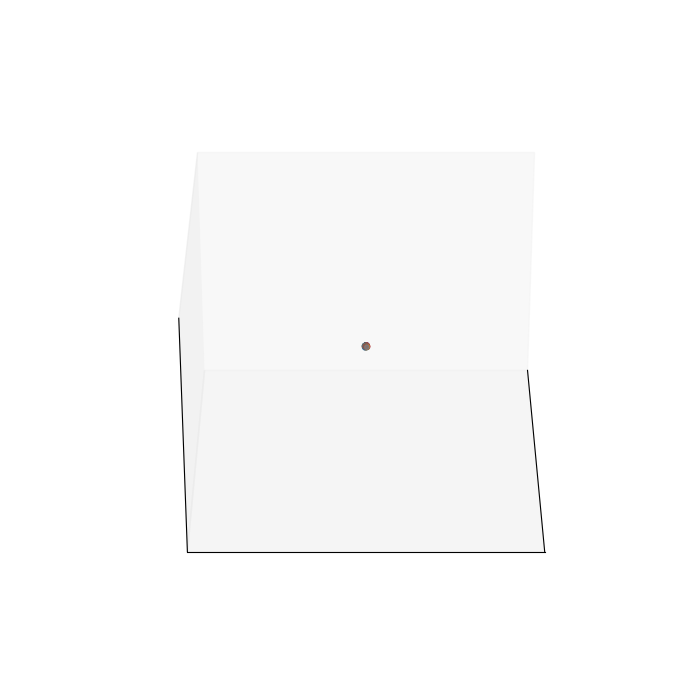

In [22]:
from helper.plots import show_with_slider_3d
show_with_slider_3d(
    projections_3d,
    labels=labels,
    interpolate=False,
    steps_per_transition=1,
    alpha=0.7,
    dataset=dataset,
    show_legend=False,
    dot_size=10, #20
)

Series 1 - Correlation: 0.9685
Series 2 - Correlation: 0.9695
Series 4 - Correlation: 0.9766
Series 8 - Correlation: 0.9778
Series 16 - Correlation: 0.9775
Mean Correlation: 0.9740


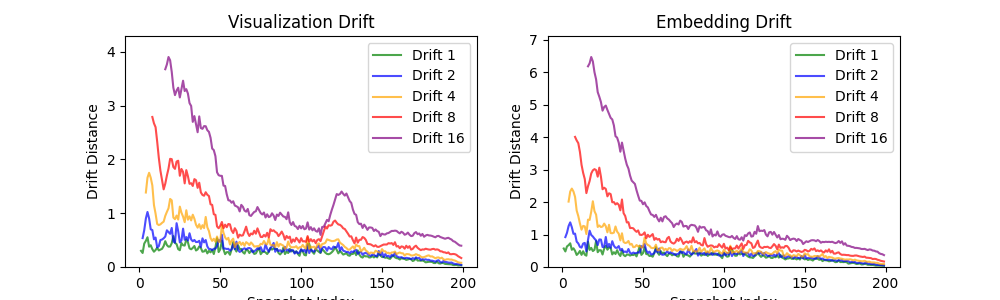

0.973983195997054

In [23]:
denoised_embeddings = denoise_projections(embedding_list, window_size=15, blend=0.9, mode='window')
visualization_drift_vs_embedding_drift(projections_3d, denoised_embeddings, embeddings=True)

### Ohter Denoising Strategies

In [24]:
projections_pca_first = generate_projections(
    embeddings_list=embedding_list,
    method='pca',
    pca_fit_basis='first',
)
projections_pca_last = generate_projections(
    embeddings_list=embedding_list,
    method='pca',
    pca_fit_basis='last',
)
projections_pca_all = generate_projections(
    embeddings_list=embedding_list,
    method='pca',
    pca_fit_basis='all',
)
projections_pca_window = generate_projections(
    embeddings_list=embedding_list,
    method='pca',
    pca_fit_basis='window',
    window_size=16,
)

In [25]:
#projections = projections_pca_window
projections = projections_pca_all

Series 1 - Correlation: 0.9563
Series 2 - Correlation: 0.9552
Series 4 - Correlation: 0.9512
Series 8 - Correlation: 0.9438
Series 16 - Correlation: 0.9578
Mean Correlation: 0.9529


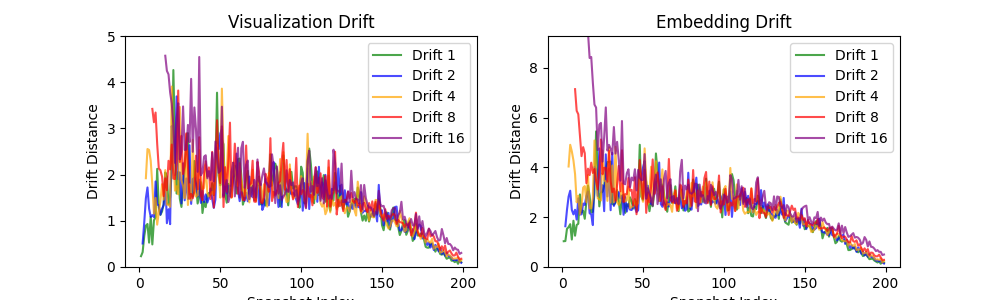

0.9528766954187153

In [26]:
visualization_drift_vs_embedding_drift(projections, embedding_drifts, verbose=True)

To smooth the low-dimensional projections we use two denoising modes:

- **Exponential (causal) blending**  
  Recursively mix each frame $P_i$ with the previous denoised output $D_{i-1}$:  
  $$D_i = (1-\alpha)\,P_i + \alpha\,D_{i-1}$$  
  Reacts quickly while damping high-frequency noise.

- **Window (moving-average) blending**  
  Compute the mean of the last $w$ raw projections:  
  $$\overline{P}_i = \frac{1}{w}\sum_{j=i-w+1}^{i}P_j$$  
  and blend it with $P_i$:  
  $$D_i = (1-\alpha)\,P_i + \alpha\,\overline{P}_i$$  
  Uses surrounding frames for stronger smoothing at the cost of lag.


In [27]:
denoised_window = denoise_projections(projections, window_size=15, blend=0.9, mode='window')
denoised_exponential = denoise_projections(projections, blend=0.8, mode='exponential')

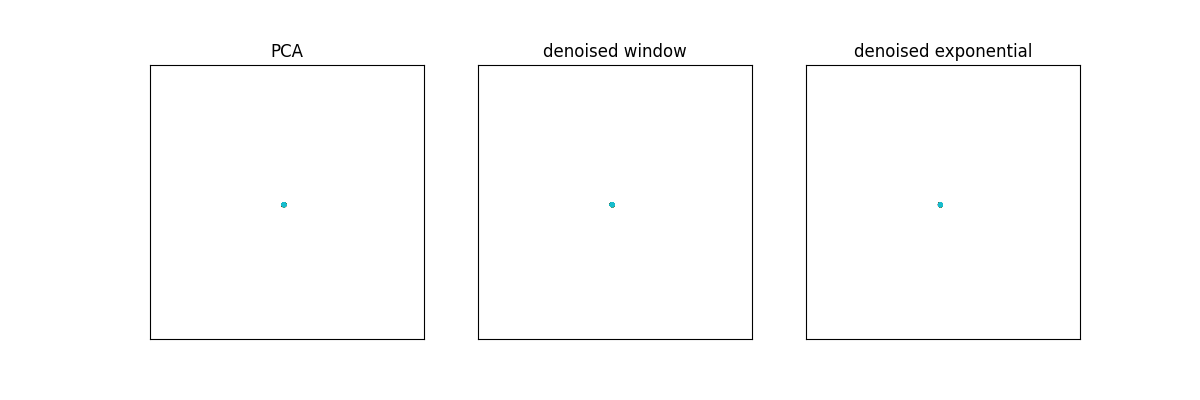

In [28]:
show_multiple_projections_with_slider(
    projections_list=[projections, denoised_window, denoised_exponential],
    labels=labels,
    titles=["PCA", "denoised window", "denoised exponential"],
    interpolate=False,
    figsize_per_plot=(4, 4),
    dataset=dataset
)

Series 1 - Correlation: 0.9312
Series 2 - Correlation: 0.9529
Series 4 - Correlation: 0.9785
Series 8 - Correlation: 0.9870
Series 16 - Correlation: 0.9890
Mean Correlation: 0.9677


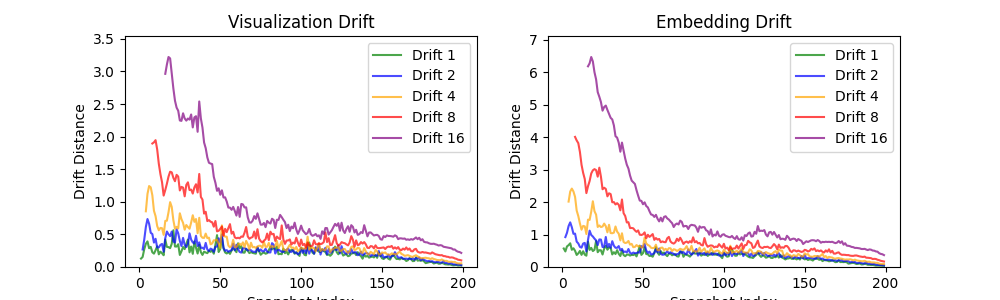

0.9677393765903816

In [29]:
denoised_embeddings = denoise_projections(embedding_list, window_size=15, blend=0.9, mode='window')
visualization_drift_vs_embedding_drift(denoised_window, denoised_embeddings, verbose=True, embeddings=True)

Series 1 - Correlation: 0.9476
Series 2 - Correlation: 0.9475
Series 4 - Correlation: 0.9634
Series 8 - Correlation: 0.9812
Series 16 - Correlation: 0.9873
Mean Correlation: 0.9654


G:\train-viz\train_viz.py:556: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 2, figsize=figsize)


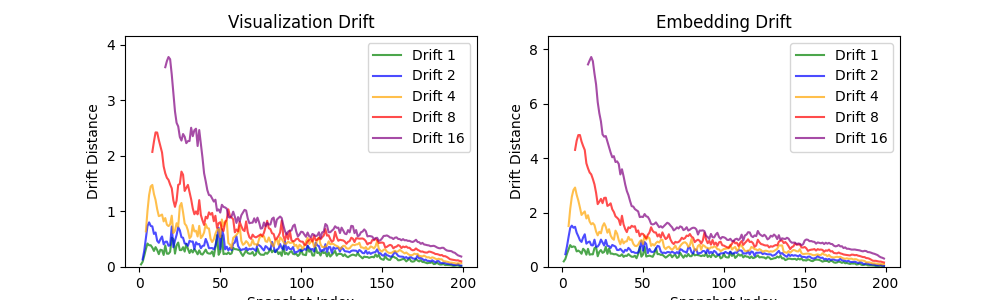

0.9653912057204366

In [30]:
denoised_exponential = denoise_projections(projections, blend=0.8, mode='exponential')
denoised_embeddings = denoise_projections(embedding_list, blend=0.8, mode='exponential')

visualization_drift_vs_embedding_drift(denoised_exponential, denoised_embeddings, verbose=True, embeddings=True)

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
window_sizes = [1, 2, 4, 6, 8, 10, 15]
blend_values = np.linspace(0, 1, 11)
correlation_results = {ws: [] for ws in window_sizes}
exponentials = []

# Run correlations
for blend in blend_values:
    for ws in window_sizes:
        denoised = denoise_projections(projections, window_size=ws, blend=blend, mode='window')
        denoised_embeddings = denoise_projections(embedding_list, window_size=ws, blend=blend, mode='window')
        corr = visualization_drift_vs_embedding_drift(denoised, denoised_embeddings, verbose=False, embeddings=True)
        correlation_results[ws].append(corr)
        
    denoised = denoise_projections(projections, blend=blend, mode='exponential')
    denoised_embeddings = denoise_projections(embedding_list, blend=blend, mode='exponential')
    corr = visualization_drift_vs_embedding_drift(denoised, denoised_embeddings, verbose=False, embeddings=True)
    exponentials.append(corr)

KeyboardInterrupt: 

In [ ]:
# Plotting
plt.figure(figsize=(8, 4))
for ws in window_sizes:
    plt.plot(blend_values, correlation_results[ws], label=f'window_size={ws}')
plt.plot(blend_values, exponentials, label=f'exponential', linewidth=3)
plt.xlabel("Blend")
plt.ylabel("Correlation")
plt.title("Correlation vs. Blend for different denoise calculations")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Define parameters
window_sizes = range(1, 20)
correlation_results = []
blend = 0.9

# Run correlations
for ws in window_sizes:
    denoised = denoise_projections(projections, window_size=ws, blend=blend, mode='window')
    denoised_embeddings = denoise_projections(embedding_list, window_size=ws, blend=blend, mode='window')
    corr = visualization_drift_vs_embedding_drift(denoised, denoised_embeddings, verbose=False, embeddings=True)
    correlation_results.append(corr)

# Plotting
plt.figure(figsize=(8, 4))
plt.plot(window_sizes, correlation_results)
plt.xlabel("Window Size")
plt.ylabel("Correlation")
plt.title("Correlation vs. Window Size")
plt.grid(True)
plt.show()

# t-SNE Visualization

In [ ]:
# Close interactivity of plots before
matplotlib.pyplot.close()

## Standard t-SNE


In [40]:
# Restore original values
embedding_list = results["subset_embeddings"].copy()
embedding_drifts = results["embedding_drifts"].copy()
print(f"{len(embedding_list)} - 1 should be {len(embedding_drifts[1])}")

200 - 1 should be 199


In [7]:
# Subsample: Every n-th element
from helper.visualization import calculate_embedding_drift

embedding_list = embedding_list[::3]
embedding_drifts = _calculate_embedding_drift(embedding_list)

In [41]:
from helper.visualization import generate_projections, denoise_projections

projections = generate_projections(
    embeddings_list=embedding_list,
    method='pca',
    pca_fit_basis='window',
    window_size=16,
)
denoised_exponential = denoise_projections(projections, blend=0.8, mode='exponential')
print(f"{len(embedding_list)} - 1 should be {len(embedding_drifts[1])}")

200 - 1 should be 199


In [42]:
from helper.visualization import generate_projections, visualization_drift_vs_embedding_drift, denoise_projections
from helper.plots import show_with_slider, show_multiple_projections_with_slider

projections_tsne = generate_projections(
    embeddings_list=embedding_list,
    method='tsne',
)

In [ ]:
%matplotlib ipympl
%matplotlib widget

show_multiple_projections_with_slider(
    projections_list=[denoised_exponential, projections_tsne],
    labels=labels,
    titles=["PCA", "t-SNE"],
    interpolate=True,
    steps_per_transition=2,
    figsize_per_plot=(5, 5),
    shared_axes=False,
)

Series 1 - Correlation: 0.6809
Series 2 - Correlation: 0.6208
Series 4 - Correlation: 0.7271
Series 8 - Correlation: 0.8503
Series 16 - Correlation: 0.8614
Mean Correlation: 0.7481


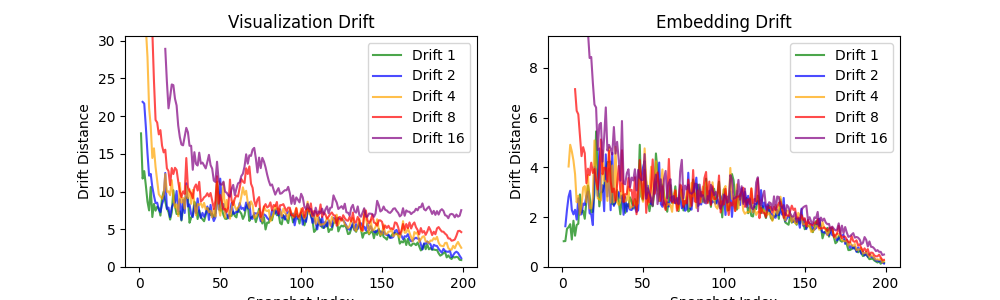

0.7481183599379098

In [44]:
visualization_drift_vs_embedding_drift(projections_tsne, embedding_drifts)

In [45]:
denoised_tsne = denoise_projections(projections_tsne, blend=0.8, mode='exponential')
denoised_embeddings = denoise_projections(embedding_list, blend=0.8, mode='exponential')

G:\train-viz\train_viz.py:993: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(nrows, ncols,


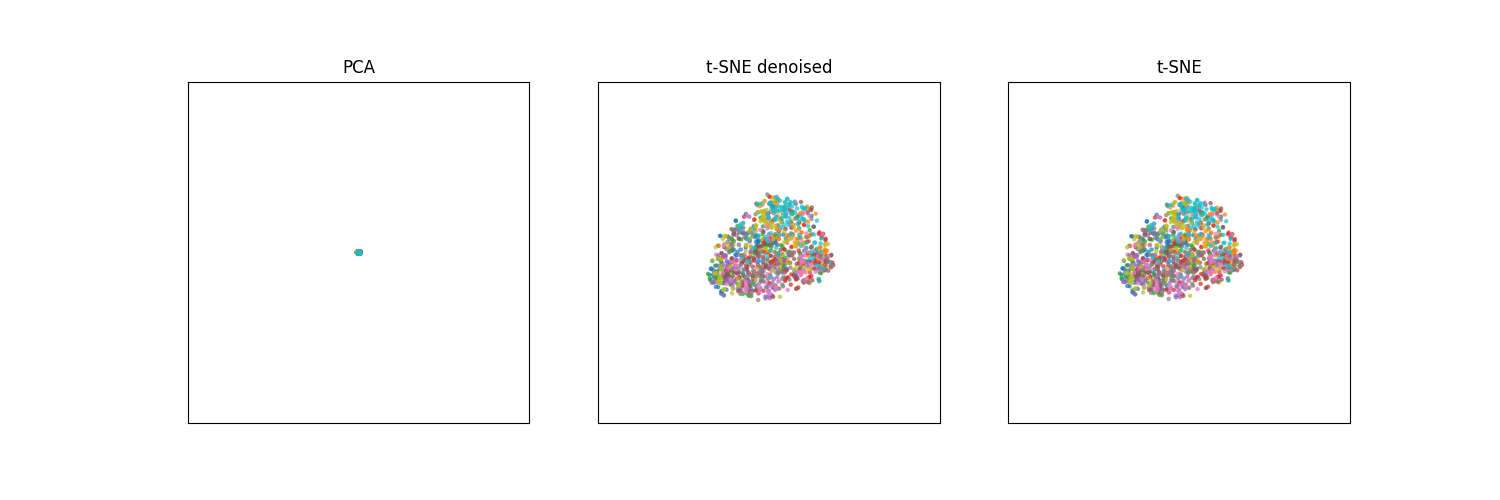

In [46]:
show_multiple_projections_with_slider(
    projections_list=[denoised_exponential, denoised_tsne, projections_tsne],
    labels=labels,
    titles=["PCA", "t-SNE denoised", "t-SNE"],
    interpolate=False,
    steps_per_transition=1,
    figsize_per_plot=(5, 5),
    shared_axes=False,
)

Series 1 - Correlation: 0.6382
Series 2 - Correlation: 0.7148
Series 4 - Correlation: 0.8090
Series 8 - Correlation: 0.8852
Series 16 - Correlation: 0.9047
Mean Correlation: 0.7904


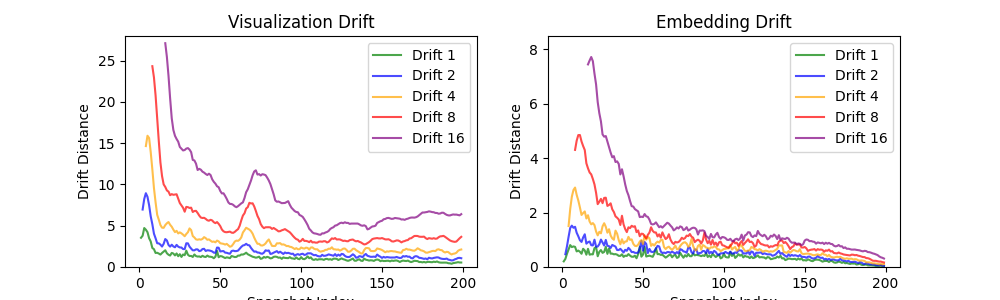

0.7903749436614532

In [47]:
visualization_drift_vs_embedding_drift(denoised_tsne, denoised_embeddings, embeddings=True)

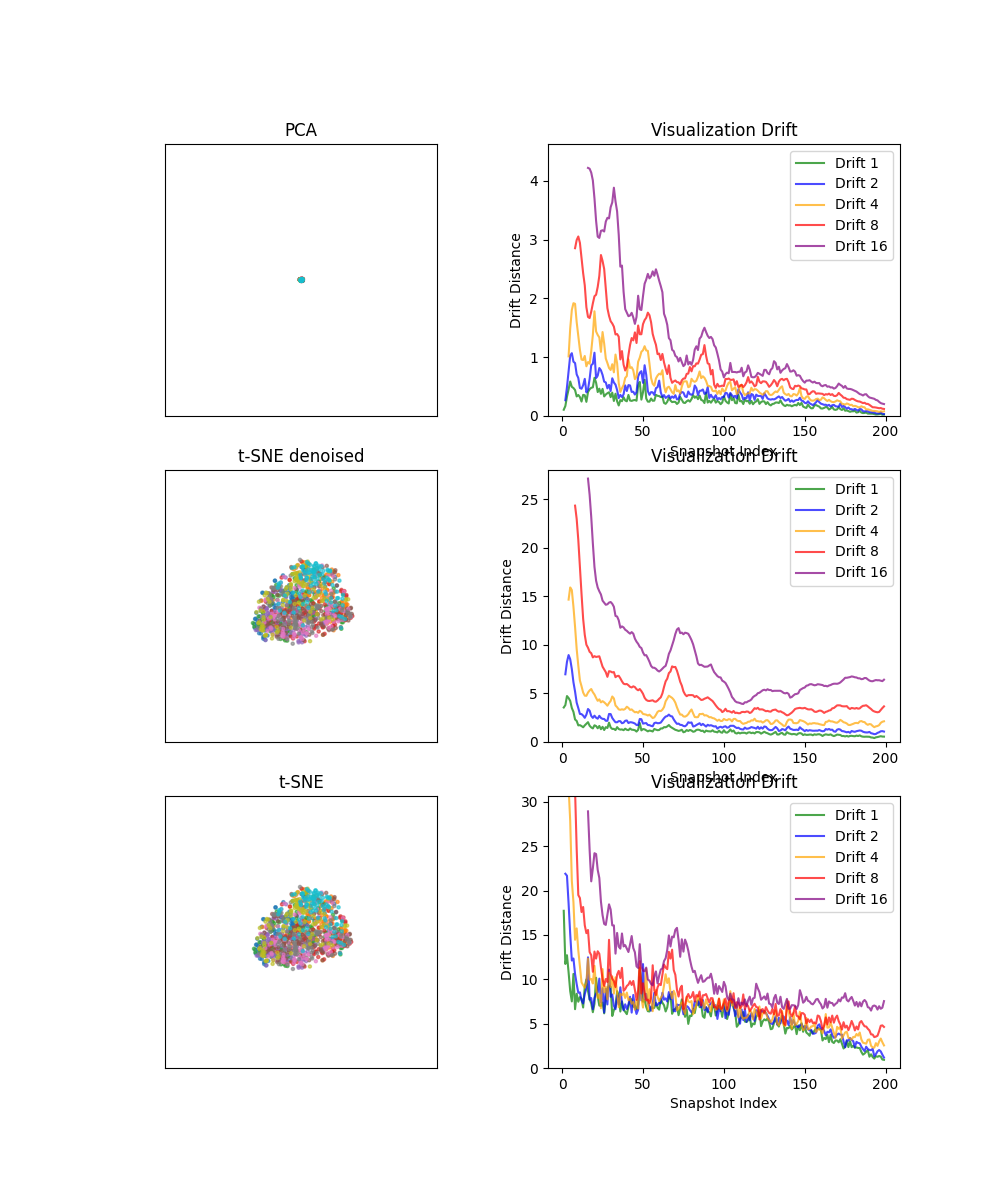

PCA: 0.7726067154976377 = [0.7326358, 0.6926500653215311, 0.7499081794307764, 0.8217544722740017, 0.8660850643917808]
t-SNE denoised: 0.5227628502837309 = [0.25790435, 0.30978617791726043, 0.5164967293126265, 0.7115403060688164, 0.8180866873623527]
t-SNE: 0.7481183599379098 = [0.6809425, 0.6207580579842218, 0.72713941813609, 0.8503194742357639, 0.8614323735377275]


In [48]:
from helper.visualization import show_projections_and_drift

show_projections_and_drift(
    projections_list = [denoised_exponential, denoised_tsne, projections_tsne],
    titles = ["PCA", "t-SNE denoised", "t-SNE"],
    labels = labels,
    embedding_drifts= embedding_drifts,
    embeddings = False,
    interpolate=False,
    steps_per_transition=5,
    figsize_embedding_drift=(6, 4),
    figsize_visualization=(4, 4),
    shared_axes=False,
    dot_size = 5,
    alpha = 0.6,
)

## t-SNE with update blending

After computing t-SNE for frame $i$, you blend it with the previous projection.
`tsne_update` is a weight in $[0,1]$:
- If `tsne_update=1`, it's exactly the original method (no blending).
- If `tsne_update=0`, you freeze to the previous frame (no update at all).
- Values like `0.2 - 3` should result in a smooth interpolation between old and new.

Result: Extra smoothing over time.
- Avoids too fast movements
- Avoids flips of dense clusters
- Can introduce lag or “stickiness,” but animations look steadier.

In [49]:
projections_tsne_avg = generate_projections(
    embeddings_list=embedding_list,
    method='tsne',
    tsne_update=0.3
)

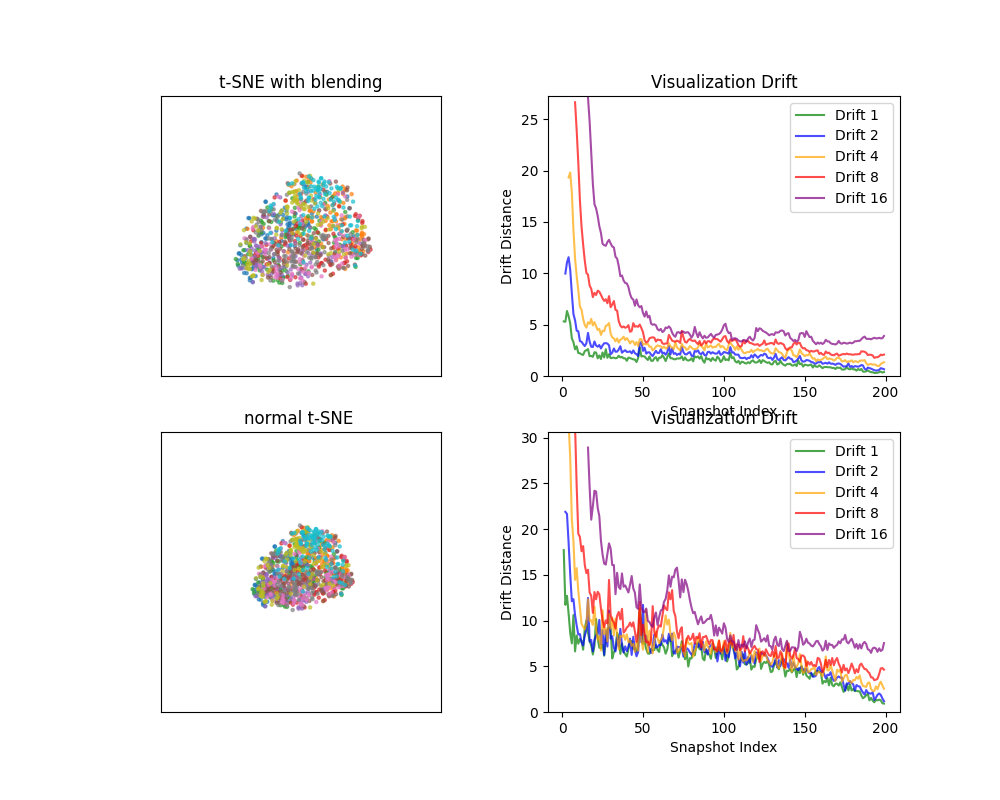

t-SNE with blending: 0.58710307962443 = [0.36562392, 0.3869474157916017, 0.5649981896437049, 0.7507199816486974, 0.8672258898822162]
normal t-SNE : 0.7481183599379098 = [0.6809425, 0.6207580579842218, 0.72713941813609, 0.8503194742357639, 0.8614323735377275]


In [50]:
show_projections_and_drift(
    projections_list = [projections_tsne_avg, projections_tsne],
    titles = ["t-SNE with blending", "normal t-SNE "],
    labels = labels,
    embedding_drifts=embedding_drifts,
    interpolate=True,
    steps_per_transition=5,
)

## t-SNE with backwards computation
Starts with the last frame
- Ensures convergence
- Improves noise in early frames as the basis is from a later and better picture

In [51]:
projections_tsne_reverse = generate_projections(
    embeddings_list=embedding_list,
    method='tsne',
    reverse_computation=True
)

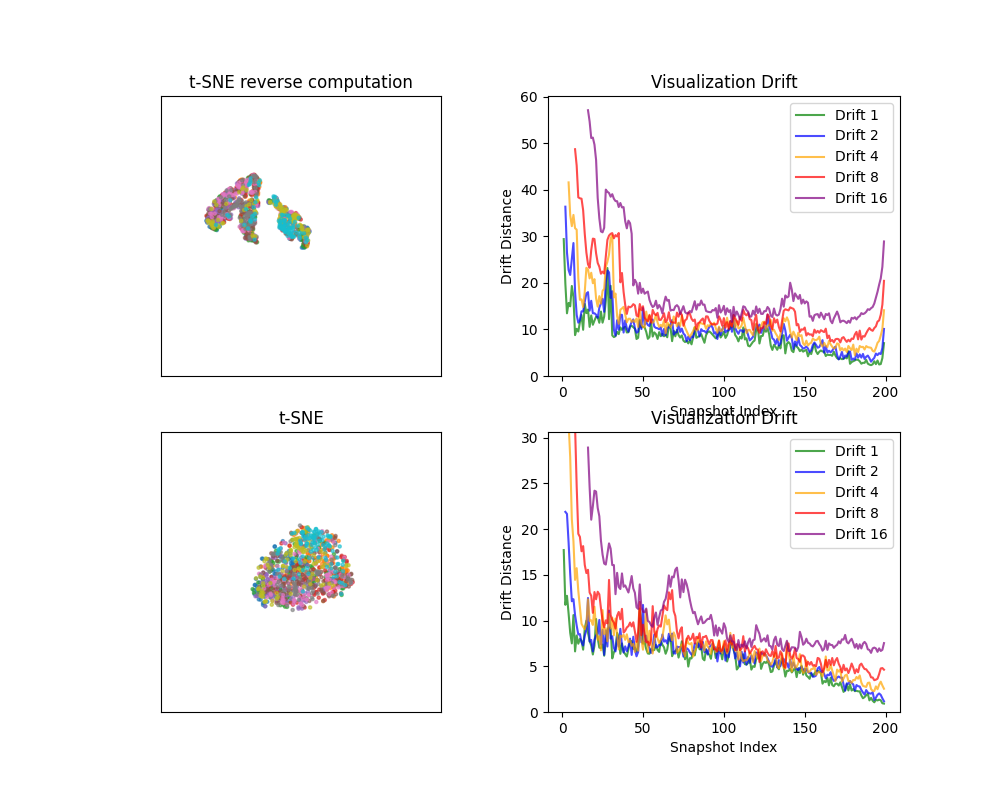

t-SNE reverse computation: 0.6469764919839371 = [0.5471412, 0.5453523739158884, 0.6451151641000001, 0.7189159466304409, 0.7783577809297895]
t-SNE: 0.7481183599379098 = [0.6809425, 0.6207580579842218, 0.72713941813609, 0.8503194742357639, 0.8614323735377275]


In [52]:
show_projections_and_drift(
    projections_list = [projections_tsne_reverse, projections_tsne],
    titles = ["t-SNE reverse computation", "t-SNE"],
    labels = labels,
    embedding_drifts=embedding_drifts,
    interpolate=True,
    steps_per_transition=5
)

In [53]:
projections_tsne_reverse_2 = generate_projections(
    embeddings_list=embedding_list,
    method='tsne',
    reverse_computation=True,
    tsne_update=0.2
)

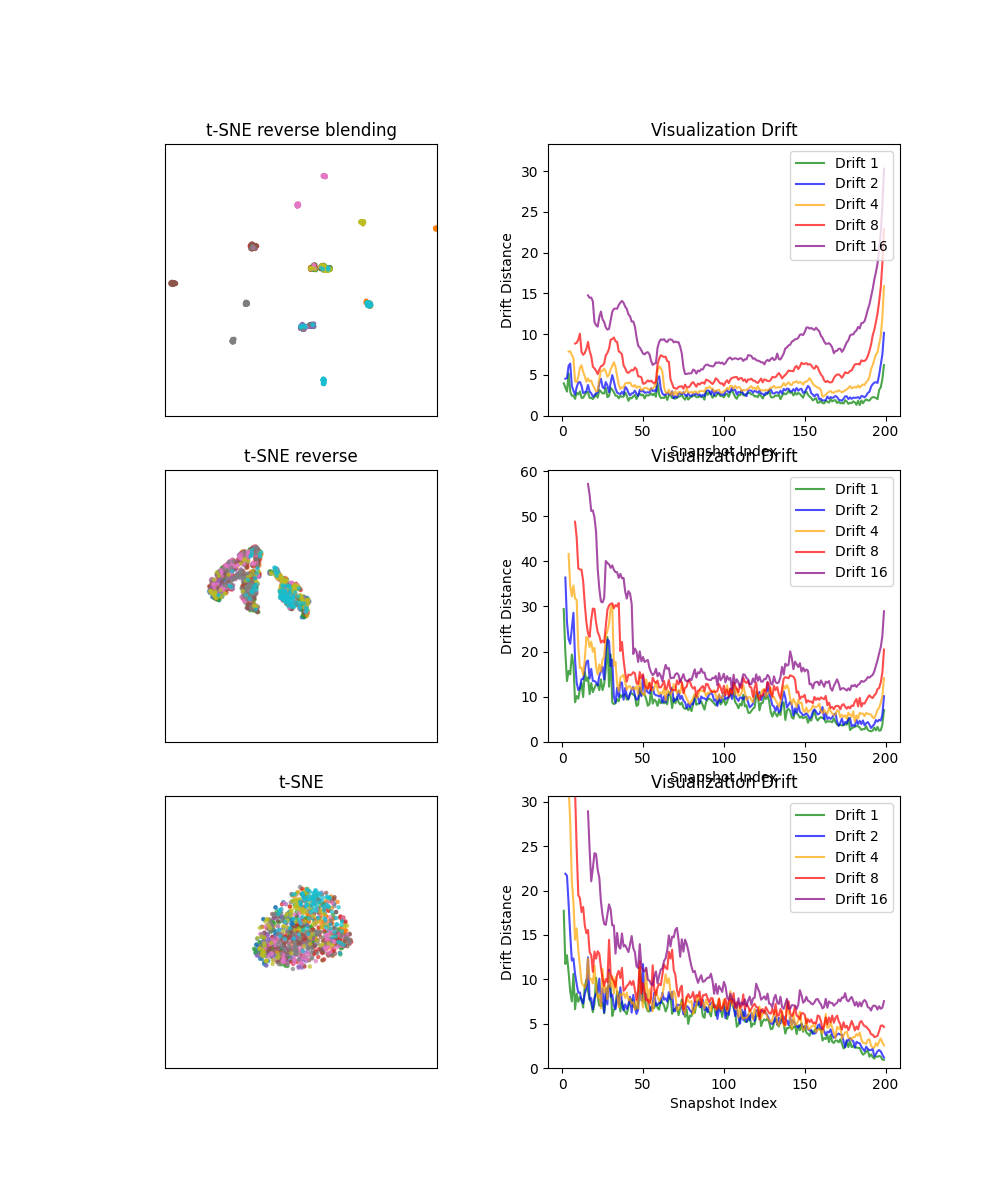

t-SNE reverse blending: -0.020743580750517472 = [0.18811981, -0.004702240744388367, -0.11359489853596055, -0.1483957231264325, -0.02514485514566403]
t-SNE reverse: 0.6469764919839371 = [0.5471412, 0.5453523739158884, 0.6451151641000001, 0.7189159466304409, 0.7783577809297895]
t-SNE: 0.7481183599379098 = [0.6809425, 0.6207580579842218, 0.72713941813609, 0.8503194742357639, 0.8614323735377275]


In [54]:
show_projections_and_drift(
    projections_list = [projections_tsne_reverse_2, projections_tsne_reverse, projections_tsne],
    titles = ["t-SNE reverse blending", "t-SNE reverse", "t-SNE"],
    labels = labels,
    embedding_drifts=embedding_drifts,
    interpolate=True,
    steps_per_transition=5
)

## t-SNE with Cosine metric

In [55]:
projections_tsne_cosine = generate_projections(
    embeddings_list=embedding_list,
    method='tsne',
    metric='cosine'
)

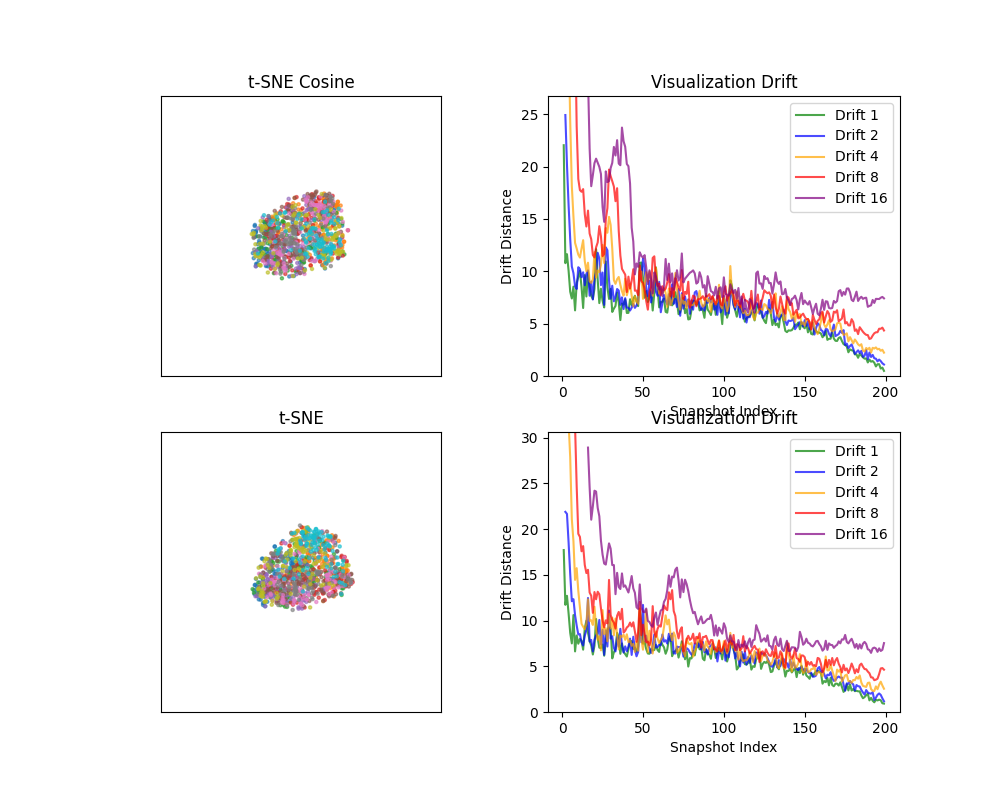

t-SNE Cosine: 0.743478200352568 = [0.68197286, 0.6710652774900294, 0.756475164193887, 0.8059519892293399, 0.8019257095596056]
t-SNE: 0.7481183599379098 = [0.6809425, 0.6207580579842218, 0.72713941813609, 0.8503194742357639, 0.8614323735377275]


In [56]:
show_projections_and_drift(
    projections_list = [projections_tsne_cosine, projections_tsne],
    titles = ["t-SNE Cosine", "t-SNE"],
    labels = labels,
    embedding_drifts= embedding_drifts,
    interpolate=True,
    steps_per_transition=5,
)

## t-SNE with random Seed

In [57]:
projections_tsne_random = generate_projections(
    embeddings_list=embedding_list,
    method='tsne',
    random_state=1106,
    tsne_init='random'
)

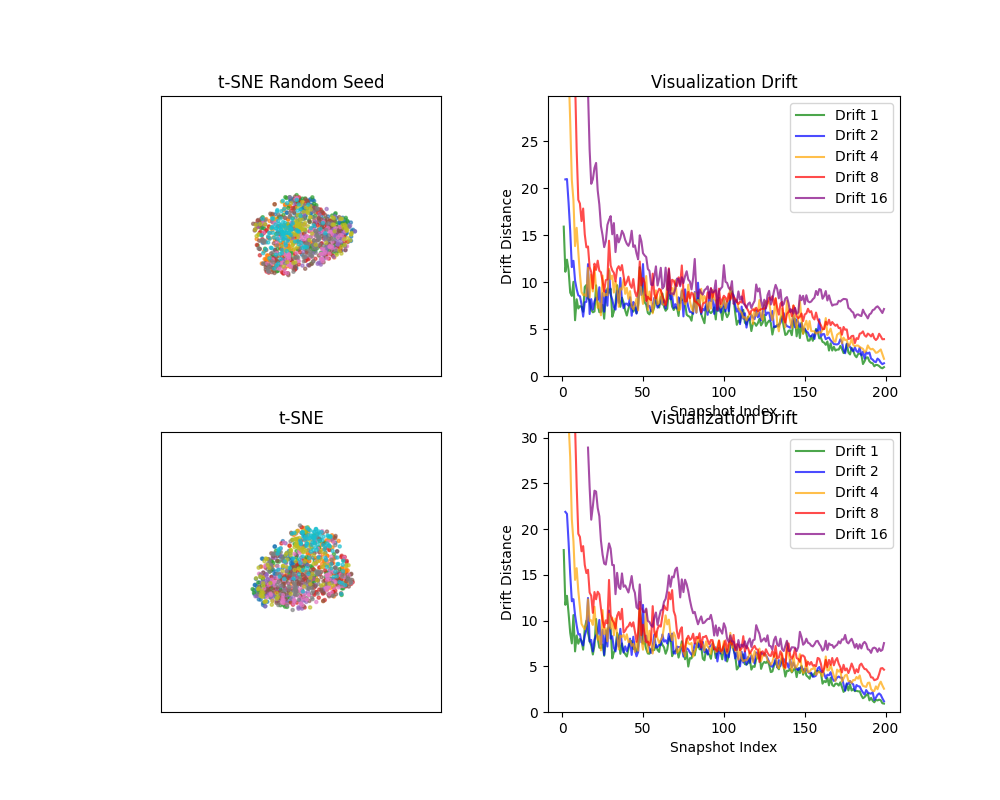

t-SNE Random Seed: 0.7808394801205611 = [0.7310587, 0.6582183625553031, 0.7473648553099659, 0.875474837347397, 0.8920806286161528]
t-SNE: 0.7481183599379098 = [0.6809425, 0.6207580579842218, 0.72713941813609, 0.8503194742357639, 0.8614323735377275]


In [58]:
show_projections_and_drift(
    projections_list = [projections_tsne_random, projections_tsne],
    titles = ["t-SNE Random Seed", "t-SNE"],
    labels = labels,
    embedding_drifts= embedding_drifts,
    interpolate=True,
    steps_per_transition=5,
)

## t-SNE Perplexity
Compare 5 - 10 - 30 - 50

In [ ]:
projections_tsne_p_5 = generate_projections(
    embeddings_list=embedding_list,
    method='tsne',
    tsne_perplexity=5
)

projections_tsne_p_10 = generate_projections(
    embeddings_list=embedding_list,
    method='tsne',
    tsne_perplexity=10
)

projections_tsne_p_50 = generate_projections(
    embeddings_list=embedding_list,
    method='tsne',
    tsne_perplexity=50
)

projections_tsne_p_30 = projections_tsne

In [ ]:
show_projections_and_drift(
    projections_list=[projections_tsne_p_5, projections_tsne_p_10,
                      projections_tsne_p_30,
                      projections_tsne_p_50],
    titles=["t-SNE Perplexity 5", "t-SNE Perplexity 10",
            "t-SNE Perpl. 30 (standard)",
            "t-SNE Perplexity 50"],
    labels=labels,
    embedding_drifts=embedding_drifts, # embedding_drifts
    interpolate=False,
    steps_per_transition=2,
    dot_size=2
)

## Combinations
Educated guesses for a good t-SNE Visualization

In [ ]:
projections_tsne_p_5_blend = generate_projections(
    embeddings_list=embedding_drifts,
    method='tsne',
    tsne_perplexity=5,
    tsne_update=0.2
)
projections_tsne_p_5_blend_3 = generate_projections(
    embeddings_list=embedding_drifts,
    method='tsne',
    tsne_perplexity=5,
    tsne_update=0.3
)

In [ ]:
show_projections_and_drift(
    projections_list=[
        projections_tsne_p_5_blend,
        projections_tsne_p_5_blend_3,
        projections_tsne_p_5,
        projections_tsne_avg,
        projections_tsne
    ],
    titles=[
        "t-SNE P5 Blending 0.2",
        "t-SNE P5 Blending 0.3",
        "t-SNE Perplexity 5",
        "t-SNE Blending",
        "t-SNE"
    ],
    labels=labels,
    embedding_drifts=embedding_drifts, # embedding_drifts
    interpolate=False,
    steps_per_transition=2,
    dot_size=2
)

# td-SNE

In [ ]:
import torch
import torch.nn.functional as F
from torch.optim import Adam
import time


class DynamicTSNE:
    def __init__(
            self,
            output_dims=2,
            verbose=True,
    ):
        self.output_dims = output_dims
        self.verbose = verbose
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def compute_affinities(self, Xs, perplexity=30.0, k_neighbors=90):
        def Hbeta(D, beta):
            P = torch.exp(-D * beta)
            sumP = torch.sum(P)
            sumP = torch.clamp(sumP, min=1e-8)
            H = torch.log(sumP) + beta * torch.sum(D * P) / sumP
            P = torch.clamp(P / sumP, min=1e-8)
            return H, P

        def compute_P(X, init_beta=None):
            t0 = time.time()

            n = X.shape[0]
            D = torch.cdist(X, X, p=2).pow(2)
            P = torch.zeros((n, n), device=X.device)
            beta = init_beta.clone() if init_beta is not None else torch.ones(n, device=X.device)
            logU = torch.log(torch.tensor(perplexity, device=X.device))
            all_tries = 0

            for i in range(n):
                distances = D[i]
                topk = torch.topk(distances, k=k_neighbors + 1, largest=False)
                idx = topk.indices[topk.indices != i][:k_neighbors]
                Di = torch.clamp(distances[idx], max=1e3)

                betamin, betamax = None, None
                H, thisP = Hbeta(Di, beta[i])
                tries = 0
                while torch.abs(H - logU) > 1e-5 and tries < 50:
                    if H > logU:
                        betamin = beta[i].clone()
                        beta[i] = beta[i] * 2 if betamax is None else (beta[i] + betamax) / 2
                    else:
                        betamax = beta[i].clone()
                        beta[i] = beta[i] / 2 if betamin is None else (beta[i] + betamin) / 2
                    H, thisP = Hbeta(Di, beta[i])
                    tries += 1
                all_tries += tries
                P[i, idx] = thisP

            if self.verbose:
                print(f"Total affinity computation time: {time.time() - t0:.2f}s, {all_tries / n} Tries")

            P = (P + P.T) / (2 * n)
            return P, beta

        X_tensor = [torch.tensor(X, device=self.device) for X in Xs]
        self.Xs = X_tensor

        Ps = []
        prev_beta = None
        for X in X_tensor:
            P, prev_beta = compute_P(X, prev_beta)
            Ps.append(P)

        self.Ps = torch.stack(Ps)
        assert not torch.isnan(self.Ps).any(), "Affinity matrix has NaN"

    def fit(self, n_epochs=1000, exaggeration=12.0, exaggeration_epochs=250, lr=200.0, lambd=0.1):
        T = len(self.Xs)
        n = self.Xs[0].shape[0]

        Y_init = []
        for X in self.Xs:
            X_cpu = X.detach().cpu().numpy()
            pca = PCA(n_components=self.output_dims)
            Y_pca = pca.fit_transform(X_cpu)
            Y_init.append(torch.tensor(Y_pca, device=self.device, dtype=torch.float32))
        
        Y = torch.stack(Y_init)
        Y.requires_grad_()

        optimizer = Adam([Y], lr=lr)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

        for epoch in range(n_epochs):
            optimizer.zero_grad()
            total_loss = 0

            if epoch < exaggeration_epochs:
                P_use = self.Ps * exaggeration
            else:
                lambd = 0
                P_use = self.Ps
            
            for t in range(T):
                Qt, _ = self._compute_lowdim_affinities(Y[t])
                loss = self._kl_divergence(P_use[t], Qt)
                if t > 0:
                    loss += lambd * F.mse_loss(Y[t], Y[t - 1])
                total_loss += loss

            total_loss.backward()
            torch.nn.utils.clip_grad_norm_([Y], max_norm=10.0)
            optimizer.step()
            scheduler.step()

            if self.verbose and (epoch % 100 == 0 or epoch == n_epochs - 1):
                print(f"Epoch {epoch}, Loss: {total_loss.item():.4f}")

        return [Y[t].detach().cpu().numpy() for t in range(T)]

    def _compute_lowdim_affinities(self, Y):
        num = 1 / (1 + torch.cdist(Y, Y, p=2).pow(2))
        num.fill_diagonal_(0.0)
        Q = torch.clamp(num / num.sum(), min=1e-5)
        return Q, num

    def _kl_divergence(self, P, Q):
        return torch.sum(P * torch.log((P + 1e-8) / (Q + 1e-8)))

In [ ]:
subset = [embedding_list[i] for i in range(10, len(embedding_list), 30)]
len(subset)
#samples_per_class = 100
#classes = 10  # assuming 1000 samples total and 100 per class
#indices = np.concatenate([np.arange(c * 100, c * 100 + samples_per_class) for c in range(classes)])
#subset = [emb[:][indices] for emb in subset]
#label_subset = [emb[:][indices] for emb in results["subset_labels"]]

In [ ]:
tsne = DynamicTSNE()
tsne.compute_affinities(subset, perplexity=30.0, k_neighbors=250)

In [ ]:
from sklearn.decomposition import PCA
projections = tsne.fit(lr=200, lambd=0.1, n_epochs=1000, exaggeration_epochs=250, exaggeration=22.0)

In [ ]:
%matplotlib widget

show_with_slider(
    projections,
    labels=results["subset_labels"],
    interpolate=False,
    steps_per_transition=4,
)

In [ ]:
matplotlib.pyplot.close()

In [ ]:
visualization_drift_vs_embedding_drift(thesne, embedding_drift_subset)

In [ ]:
Y = tsne_with_live_callback(embedding_list[10],
                        labels=results["subset_labels"][0],
                        perplexity=30,
                        lr=200,
                        n_iter=10000,
                        interval=5)

In [ ]:
from openTSNE import TSNE
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output

def tsne_with_live_callback(X, labels=None, perplexity=30, lr=200, n_iter=1000, interval=50):
    fig, ax = plt.subplots(figsize=(6, 6))

    def callback(iteration, error, Y):
        if iteration % interval == 0 or iteration == n_iter - 1:
            ax.clear()
            if labels is not None:
                ax.scatter(Y[:, 0], Y[:, 1], c=labels, cmap='tab10', s=5, alpha=0.7)
            else:
                ax.scatter(Y[:, 0], Y[:, 1], s=5, alpha=0.7)
            ax.set_title(f"t-SNE at iter {iteration}")
            ax.set_xticks([])
            ax.set_yticks([])
            clear_output(wait=True)
            display(fig)

    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        learning_rate=lr,
        n_iter=n_iter,
        initialization="pca",
        callbacks=callback,
        callbacks_every_iters=interval,
        verbose=False,
    )

    try:
        Y = tsne.fit(X)
    except KeyboardInterrupt:
        print("Interrupted, returning current state.")
        return tsne

    return Y

# OPENTSNE Dynamic

In [ ]:
import numpy as np
from openTSNE import TSNE
from sklearn.decomposition import PCA


class DynamicTSNE_2:
    def __init__(self, perplexity=30, n_iter=1000, init='pca', random_state=None):
        """
        init: 'pca', 'random', or 'previous'
        """
        assert init in ['pca', 'random', 'previous']
        self.perplexity = perplexity
        self.n_iter = n_iter
        self.init = init
        self.random_state = random_state

    def fit_transform(self, Xs):
        """
        Xs: List of np.ndarray (each shape: [n_samples, n_features])
        Returns: List of np.ndarray (each shape: [n_samples, 2])
        """
        embeddings = []
        previous_embedding = None

        for i, X in enumerate(Xs):
            print(i)
            if i == 0 or self.init == 'pca':
                init_embedding = PCA(n_components=2).fit_transform(X) if self.init != 'random' else 'random'
            else:
                init_embedding = previous_embedding

            tsne = TSNE(
                n_jobs=-1,
                perplexity=self.perplexity,
                n_iter=self.n_iter,
                initialization=init_embedding,
                random_state=self.random_state,
                verbose=True
            )
            embedding = tsne.fit(X)
            embeddings.append(embedding)
            previous_embedding = embedding

        return embeddings

In [ ]:
dynamic_tsne = DynamicTSNE_2(n_iter=500, init='previous', random_state=42)
projections_2 = dynamic_tsne.fit_transform(subset)

In [ ]:
%matplotlib widget

show_with_slider(
    projections_2,
    labels=results["subset_labels"],
    interpolate=False,
    steps_per_transition=4,
)

# MODERN DYNAMIC TNSNE

In [ ]:
import numpy as np

subset = [embedding_list[i] for i in range(0, len(embedding_list), 5)]
samples_per_class = 4
classes = 100  # assuming 1000 samples total and 100 per class
indices = np.concatenate([np.arange(c * 10, c * 10 + samples_per_class) for c in range(classes)])
subset = [emb[:][indices] for emb in subset]
label_subset = [emb[:][indices] for emb in results["subset_labels"]]
len(subset)

In [ ]:
label_subset[0]

In [ ]:
modern_dynamic_tsne = ModernDynamicTSNE(
    n_epochs=500,
    perplexity=30,
)
projections_3 = modern_dynamic_tsne.fit_transform(subset)

In [ ]:
projections_tsne = generate_projections(
    embeddings_list=subset,
    method='tsne',
)

In [ ]:
modern_dynamic_tsne

In [ ]:
show_multiple_projections_with_slider(
    projections_list=[projections_tsne, projections_3],
    labels=results["subset_labels"],
    titles=["t-SNE", "Dynamic t-SNE"],
    interpolate=False,
    figsize_per_plot=(4, 4),
    dataset=dataset
)

In [ ]:
show_with_slider(
    projections_3,
    labels=label_subset,
    interpolate=False,
    steps_per_transition=4,
    dataset=dataset,
    alpha=0.7
)

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import torch
import torch.nn.functional as F
from torch.optim import SGD


class ModernDynamicTSNE:
    def __init__(
        self,
        perplexity=30,
        n_epochs=1000,
        output_dims=2,
        initial_lr=2400,
        final_lr=200,
        lr_switch=250,
        init_stdev=1e-4,
        initial_momentum=0.5,
        final_momentum=0.8,
        momentum_switch=250,
        lmbda=0.0,
        sigma_iters=50,
        verbose=True,
        device=None
    ):
        self.perplexity = perplexity
        self.n_epochs = n_epochs
        self.output_dims = output_dims
        self.initial_lr = initial_lr
        self.final_lr = final_lr
        self.lr_switch = lr_switch
        self.init_stdev = init_stdev
        self.initial_momentum = initial_momentum
        self.final_momentum = final_momentum
        self.momentum_switch = momentum_switch
        self.lmbda = lmbda
        self.sigma_iters = sigma_iters
        self.verbose = verbose
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    def _hbeta(self, D, beta):
        P = torch.exp(-D * beta)
        sumP = torch.sum(P)
        sumP = torch.clamp(sumP, min=1e-8)
        H = torch.log(sumP) + beta * torch.sum(D * P) / sumP
        P = P / sumP
        return H, P

    def _binary_search_perplexity(self, D, tol=1e-5):
        n = D.shape[0]
        sigmas = torch.ones(n, device=self.device)
        P = torch.zeros((n, n), device=self.device)

        logU = np.log(self.perplexity)
        for i in range(n):
            betamin = None
            betamax = None
            beta = sigmas[i]
            Di = D[i][torch.arange(n) != i]
            H, thisP = self._hbeta(Di, beta)

            tries = 0
            while torch.abs(H - logU) > tol and tries < self.sigma_iters:
                if H > logU:
                    betamin = beta
                    beta = beta * 2 if betamax is None else (beta + betamax) / 2
                else:
                    betamax = beta
                    beta = beta / 2 if betamin is None else (beta + betamin) / 2
                H, thisP = self._hbeta(Di, beta)
                tries += 1
            P[i, torch.arange(n) != i] = thisP
        return (P + P.T) / (2 * n)

    def _precompute_Ps(self, Xs):
        Ps = []
        for X in Xs:
            D = torch.cdist(X, X).pow(2)
            P = self._binary_search_perplexity(D)
            Ps.append(P)
        return Ps

    def _compute_cost(self, Ys, Ps):
        total_kl = 0
        for Y, P in zip(Ys, Ps):
            Q_num = 1 / (1 + torch.cdist(Y, Y).pow(2))
            Q_num.fill_diagonal_(0)
            Q = Q_num / Q_num.sum()
            kl = torch.sum(P * torch.log((P + 1e-8) / (Q + 1e-8)))
            total_kl += kl
        smoothness = sum((Ys[i] - Ys[i + 1]).pow(2).sum() for i in range(len(Ys) - 1))
        return total_kl + self.lmbda * smoothness / (2 * Ys[0].shape[0])

    def fit_transform(self, Xs_np):
        Xs = [torch.tensor(X, device=self.device, dtype=torch.float32) for X in Xs_np]
        T = len(Xs)
        N = Xs[0].shape[0]

        # Init Ys with PCA
        Ys = [
            torch.tensor(PCA(n_components=self.output_dims).fit_transform(X.cpu().numpy()),
                         device=self.device, dtype=torch.float32, requires_grad=True)
            for X in Xs
        ]

        # Precompute all P matrices once
        Ps = self._precompute_Ps(Xs)

        optimizer = SGD(Ys, lr=self.initial_lr, momentum=self.initial_momentum)

        for epoch in range(self.n_epochs):
            if epoch == self.lr_switch:
                for param_group in optimizer.param_groups:
                    param_group['lr'] = self.final_lr
            if epoch == self.momentum_switch:
                for param_group in optimizer.param_groups:
                    param_group['momentum'] = self.final_momentum

            optimizer.zero_grad()
            loss = self._compute_cost(Ys, Ps)
            loss.backward()
            optimizer.step()

            if self.verbose and (epoch % 100 == 0 or epoch == self.n_epochs - 1):
                print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

        return [Y.detach().cpu().numpy() for Y in Ys]